# `**Important**`

## This Notebook needs a complimentary `data` folder to run correctly. As the webscraping code runs, the folder will fill with the necessary .csv files for our data analysis.

## Additionally, the webscraping has a tendency to fail due to factors out of our control (i.e. paywalls on websites, infinite scroll websites, etc.). If the code gets stuck at the webscraping, please run again. If it gets stuck at the same topic, retry several times and if that fails, delete that topic/question from the respective .csv file and re-run. Sorry for the inconvenience.

## Finally, make sure that when/if you need to re-run the webscraping, empty the data file or else the data analysis might not work.

# **Is Google's Web Browser Biased?**
By Group 15 - Visual Vultures - Justin Dean, Liam May, Nick Iman, Anthony Merlin, Aidan Shea

# **Question**
Today, information is more accessible and widespread than ever before. However, a significant portion of the information consumed by the population comes from web browsers. Because of the centralized nature of web browsers, they can act as super-spreaders of information bias and, if they so desired, can directly influence the population by controlling the pages consumers see first. 

Google is one such browser. We tested the top results given by Google in response to current polarizing issues with the goal of determining if there was significant bias among the results.

Is Google biased in the results it presents?

**Methods**

To effectively answer this question, we needed to select a set of search queries that would return 'good' data. This is as important as the data analysis itself. We chose to go with two separate query sets to test for bias:

* A bipolar topic set - this set is comprised of queries that don't have a clear 'yes' or 'no' answer. Think search terms that often return articles split along political party lines (i.e. Republican vs. Democrat). This provides an idea of the ethics base of Google depending on the sentiment it returns and should broadly highlight bias.

* A bipolar question set - this set is comprised of questions-based queries that instigate a biased response. Think 'yes' or 'no' questions on topics such as healthcare, government policies, et cetera. The benefit of utilizing questions is that it allows us to develop our own analysis dataset based on whether google returns a 'yes' or a 'no'. Then, utilizing sentiment analysis, we can determine if Google is suggesting either a 'yes' or 'no'.

With these sets created, we employed web-scraping on Google search results from various queries. The goal of this web-scraping was to identify URLs that contain relevant articles/information on the query topics and gather that information from those articles. The topics we will be querying for this analysis will be displayed in a later section.
* The Google website: https://www.google.com/  

Data analysis was then performed on the 'cleaned' data to determine trends in sentiment for each topic. Visualizations were used to display our analysis in an understandable manner. Further analysis was performed to determine whether bias was influenced by text characteristics (i.e. length, number of sentiment words, etc.).

**Datasets**

* To detemine the sentiment on the search results provided by Google for each particular topic, we utilized sentiment analysis to determine if the text data within the resulting URLs had a significant positive or negative connotation. The sentiment analysis dataset we used was created by a professor at the Technical University of Denmark, Finn Neilson [1].

* We also manually created a political ideology dataset that corresponds with the 'yes' answers to the bipolar questions dataset. This was made subjectively, however, each group member participated with the goal of creating the least-biased dataset we could.


**Assumptions and Limitations**

Some assumptions need to be made before we performed our analysis:
* Unbiased text should contain approximately the same number of positive and negative sentiment words, if any at all.
* Polarizing topics often have split conclusions, so any positive or negative trends in the sentiment of Google's search results supports potential bias.

Also, we needed to select gramatically specific topics such as 'United States 2024' because of two things. The first is that the topics are directly used in the HTML requests, so they need to be fitting for a search query. The second reason is that including the date '2024' refines the search results to the relavent and updated articles that the every day user sees, and removes general data such as wiki and history pages.

# **Analysis**

## *Web-scraping and Text-cleaning*
To start, we need to import some tools: `requests` is a HTTPS request library, `re` or Regular Expression is a module to help with string manipulation, `datetime` is a module to aid in timestamping, `os` to aid in file management, and `csv` to help with reading and writing data.

In [1]:
#Coding from Liam May

import requests   # pip3 install requests (for getting search page from google)
import re #regex for parsing through request content
from datetime import datetime #for time stamping data
import os
import csv

To give us the ability to switch the querys we want to analyze, the following function reads a .txt file, Querys.txt, and returns a list of the querys as string elements:

In [2]:
#reads the data from each querys web data
def read_csv(filePath):
    file = open(filePath, newline='')
    reader = csv.reader(file)
    data = [item for row in reader for item in row]
    if data[0][:3] == "ï»¿":
        data[0] = data[0][3:]
    if data[0][0] == '\ufeff':
        data[0] = data[0][1:]
    return data

For each query, a URL is created with the first part being "https://www.google.com/search?q=" and the next part being the query string for searching google. Then, a html request is sent to this address, and the page contents are stored as a string. Regex is then used to to find strings that start with 'https:' and end with '&.' This will return all embedded links on the web page. Any google or twitter link is removed to improve result accuracy and ensure google help links aren't included. Duplicate links are also removed.

In [3]:
#catches any connection errors that may occur
def htmlSecureRequest(url):
    header = {'user_agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
    try:
        response = requests.get(url, headers=header) #requests website html data 
        return response
    except Exception as e:
        print("Connection Failed, Skipping URL or Retrying Query . . . ")
        return None

For each link, an html request is sent, and if a response is given we continue with that page content. If not we discard the link. This process will also be utilized when requesting individual URLs.

In [4]:
#function for returning data on a singular search term
def googleSearchLinks(searchTerm):
    url = "https://www.google.com/search?q="+searchTerm
    
    current_time = datetime.now() #gets the time of the request
    response = htmlSecureRequest(url) #makes the requests
    if response == None:
        return None

    https_strings = re.findall(r'https://\S+?(?=&|$)', str(response.content)) #gets the links from the html data
    filtered = [https for https in https_strings if "google.com" not in https and "twitter.com" not in https] #removes all links that are google or twitter related
    filteredUnique = list(set(filtered)) #removes duplicate urls
    
    
    timeStamped = [[searchTerm],[current_time.month, current_time.day, current_time.year, current_time.hour, current_time.minute],filteredUnique]
    #labeled and timestamped urls
    return timeStamped

The second half of the process includes scraping the pages of these links for any relevant text. Once we get the link's page content, we yet again use regex to take the data inside any `<p>...</p>` sections. This will get most of the text from most sources, enough for an analysis. These are then filtered down by length and text content (to get rid of interface text and unique pTag data). Finally, symbols within the pTags that are not alphabetic are either removed or replaced by their correct counter part. These strings are then combined together into one long string. 

In [5]:
   
#gets the main text content from a url
def getArticle(url):
    pTags = getPTags(url)
    if pTags == None:
        return None
    cleanTags = cleanPTags(pTags)
    article = joinStrings(cleanTags)
    return article

#gets the main text content for each url
def getArticles(urls):
    articles = []
    for url in urls:
        article = getArticle(url)
        if(len(article)>0):
            print("Succesfully gathered text from: "+url)
            articles.append([url,article])
    return articles
    
#gets all of the ptag data from a url
def getPTags(url): 
    response = htmlSecureRequest(url)
    if response == None: #dont do anything if HTML request failed
        return None
    
    https_strings = re.findall(r'<p[^>]*>(.*?)</p>', str(response.content)) #gets the pTags from the html data
    
    return https_strings

#cleans each pTag, removing it if deemed not important to the main text
def cleanPTags(pTags):
    pTags = [pTag for pTag in pTags if len(pTag) >= 60 and "</path>" not in pTag and "{" not in pTag]
    #gets rid of ptags with short text, html structural data, and JSON data
    
    cleaned_strings = []
    #list of cleaned pTags
    for tag in pTags:
        clean_tag = re.sub(r'<a\s+[^>]*>(.*?)</a>', r'\1', tag) #removes <a> tags, but keeps text content
        clean_tag = re.sub(r'<[^>]*>', '', clean_tag) #removes all other tags inlcuding inner content
        clean_tag = re.sub(r'\\x.{2}', ' ', clean_tag) #removes any hex data
        clean_tag = re.sub(r'&[^;]*;', ' ', clean_tag) #removes any &...; symbols
        clean_tag = clean_tag.replace('\\n', '') #removes whitespace data
        clean_tag = clean_tag.replace('\\r', '')
        clean_tag = clean_tag.replace('\\t', '')
        clean_tag = clean_tag.replace('\\', '') #gets rid of any remaining \ chars
        clean_tag = re.sub(r'[^\w\s.?!]', '', clean_tag) #removes all punctuation marks except for ending punctuation
        clean_tag = re.sub(r'\s+', ' ', clean_tag) #replaces all whitespace sections with a singular space
        cleaned_strings.append(clean_tag) #adds the cleaned tag to the list
        
    return cleaned_strings

#joins a list of strings into one string
def joinStrings(strings):
    joined = ""
    for string in strings:
        joined = joined + " " + string
    return joined

The final part of the process is creating a .csv data file for each query that includes two columns: a URL column containing the full URL used for the request, and a text column containing the consolidated text data from within the URL.

In [6]:
#writes text data from links gathered from a google search to query specific files
#writes text data from links gathered from a google search to query specific files
def saveQueryData(querys):
    queryNum = 0
    articles = 0        
    for query in querys: #for each query
        filePath = "data/"+query+".csv"
        file = open(filePath, "w") #creates new file with file name
        data = googleSearchLinks(query) #gets the search data
        
        #if the request fails
        if data == None:
            file.close() #close the current file
            os.remove(file.name) #delete the current file
            saveQueryData(querys[queryNum:]) #try to get google webpage data again starting at the current file
            return None #end this branch of the code
        
        file.write(str(data[1][0])+","+str(data[1][1])+","+str(data[1][2])+","+str(data[1][3])+","+str(data[1][4])+"\n")
        #write the date
        
        #write the urls
        for url in data[2]:
            article = getArticle(url)
            if article != None and (len(article)>1000): #if the HTML request went through and the article text exists
                if len(article)>32750:
                    file.write(url+","+article[:32750]+"\n") #write the data to the csv
                    articles = articles + 1
                    print("Succesfully gathered text from: "+url)
                else:
                    file.write(url+","+article+"\n") #write the data to the csv
                    articles = articles + 1
                    print("Succesfully gathered text from: "+url)
            #otherwise we skip the link
        
        #lets the user know the search is done
        print("Updated "+filePath+" with Search Data")
        queryNum = queryNum + 1 #keeps track of the number of querys searched in case of a retry
        file.close() #closes the file once all data is written
        
    #calculates the average number of source per query
    print("Completed Google Search Requests")

With the process now defined, we can perform the web-scraping and text-analysis.

In [7]:
#NOTE: THIS CODE TAKES A LONG TIME TO RUN DUE TO THE NATURE OF HTML REQUESTS

# topics = read_csv("bipolar-topics.csv")
# saveQueryData(topics)

# *Data Processing*
With the data consolidated within querys specific .csv files, we can now perform sentiment analysis to determine bias within each URL's text data.

Before we get started, we should discuss the sentiment analysis dataset we chose to use for this project. The dataset is called 'AFINN-en-165.txt', and it was created by a Dutch professor from the Technical University of Denmark, Finn Neilson [1]. The reason for its selection is that it has a free-use copyright liscense and contains over 3000 english words with associated sentiment ratings, ranging from -5 (completely negative) to 5 (completely positive).



## Bipolar Topic Analysis

This first part of this data processing will be on the bipolar topic set.


To start, we need to import `pandas` because it will be our main tool for managing the topic .csv data within our Notebook.

In [8]:
#Code by Nick Iman and Liam May

import pandas

Here is a list of the topics for this analysis:

In [9]:
#gets topics from external .csv file
topics = read_csv("bipolar-topics.csv")
topics

['abortion 2024',
 'minimum wage 2024',
 'immigration 2024',
 'election winner 2024',
 'gun control 2024',
 'ukraine aid 2024',
 'transgender 2024',
 'israel 2024',
 'palestinie 2024',
 'tiktok ban 2024',
 'mail in ballots 2024',
 'protests 2024',
 'homeless in cities 2024',
 'january 6 2021']

Because we are performing analysis on several different querys, we need to find a way to keep the data organized by query. To do this, Two lists are created from the data: a list of the querys stored in `querys`, and a list of the consolidated text strings for each query stored in `querysCSV`. These two lists are then utilized to create a dictionary, `querysDict`, that keys each query to its respective DataFrame.

In [10]:
def queryDataDictionary(querys):
    querysData = []
    for query in querys:
        data = read_csv("data/"+query+".csv")
        urls = data[5::2]
        websites = [url.split('/')[2] for url in urls]
        texts = data[6::2]
        querysData.append(pandas.DataFrame({'URL': urls, 'Website': websites, 'Words': texts}))

    querysDict = {querys[x]: querysData[x] for x in range(len(querys))}
    return querysDict

Now we will define the main sentiment analysis function. 

This function needs to be built with the 'end data' in mind that will ultimately be used for analysis. Because the text information will likely be different between each URL, 'average' variables come to mind, such as `average_sentiment` and `average_sentiment_allWords`. These variables will need to be calculated using `word_count`, `sentiment_count`, and `sentiment_sum`.

In order to extract these variables, the text data is split into a list of words. From the list of words, the word count is extracted. Each word in the list is compared with `sentiment` to determine if the word has a sentiment value. The number of sentiment words is counted and their values summed.

Finally, a final dictionary is created and returned with the querys and their 'cleaned' DataFrames.

In [11]:
def sentimentAnalysis(querysDict, sentimentDF):
    newQuerysDict = querysDict.copy()
    for query in querysDict.keys():
        #print(query+":")
        #creates analysis variables    
        word_count = []
        sentiment_count = []
        sentiment_sum = []
        average_sentiment = []
        average_sentiment_allWords = [] 
        
        #text analysis
        for text in querysDict[query].Words.tolist():    #iterates throught the article texts
            text_words = text.replace('.','').replace('!','').replace('?','').lower().split()    #splits the text into a list of words
            text_words = [word for word in text_words if word != '']
            word_count.append(len(text_words))  #counts all of the words and adds it to the word_count list

            text_sentimentCount = 0
            text_sentimentSum = 0

            for word in text_words:     #iterates through the sentiment analysis dataset
                if word in sentimentDF.Word.to_list():    #checks if the current word matches a word in the dataset
                    sentimentValue = sentimentDF.SentimentValue[sentimentDF.Word == word]
                    sentimentValue = sentimentValue.tolist()                            #dont even ask bro its the only way I could get it to work
                    text_sentimentSum = text_sentimentSum + int(sentimentValue[0])          #feel free to make it look pretty
                    text_sentimentCount = text_sentimentCount + 1

            sentiment_count.append(text_sentimentCount)     #adds sentiment count, sum to appropriate lists
            sentiment_sum.append(text_sentimentSum)

            if text_sentimentCount != 0:
                average_sentiment.append(text_sentimentSum/text_sentimentCount)
            else:
                average_sentiment.append(0)
                
            if len(text_words) != 0:
                average_sentiment_allWords.append(text_sentimentSum/len(text_words))
            else:
                average_sentiment_allWords.append(0)

        #creates the main DataFrame to store analysis variables
        newQuerysDict[query]['Word Count'] = word_count
        newQuerysDict[query]['Sentiment Word Count'] = sentiment_count
        newQuerysDict[query]['Sentiment Total'] = sentiment_sum
        newQuerysDict[query]['Average Sentiment per Sentiment Word'] = average_sentiment
        newQuerysDict[query]['Average Sentiment per Word'] = average_sentiment_allWords
        print("Completed Sentiment Analysis on "+query)  
        
    return newQuerysDict

Now that the sentiment analysis has been performed and we have a dictionary keying each query to its DataFrame, we must consolidate the information in each query DataFrame into one easily understandable DataFrame. To do this, we can use a pandas reduction method. The `.mean()` is the best method to use because it best characterizes the articles within each query.

The following is the function that performs this reduction:

In [12]:
#Code by Nick Iman

def reduceQuerys(querysDict):

    #establishes the 'average' variables for the reduced table
    average_word_count = []
    average_sentiment_count = []
    average_sentiment_sum = []
    average_sentiment_sentimentWord = []
    average_sentiment_word = []

    #iterates through each query table
    for query in querysDict.keys():
        
        average_word_count.append(querysDict[query]['Word Count'].mean())      #calcualtes the average word count from the query articles
        average_sentiment_count.append(querysDict[query]['Sentiment Word Count'].mean())      #calculates the average sentiment word count from the query articles
        average_sentiment_sum.append(querysDict[query]['Sentiment Total'].mean())       #calculates the average total sentiment from the query articles
        average_sentiment_sentimentWord.append(querysDict[query]['Average Sentiment per Sentiment Word'].mean())     #calculates the average sentiment per sentiment word from the query articles
        average_sentiment_word.append(querysDict[query]['Average Sentiment per Word'].mean())       #caluclates the average sentiment per word from the query articles

    #creates the new query DataFrame
    queryTable = pandas.DataFrame({'Query':querysDict.keys(),'Average Word Count':average_word_count, 'Average Sentiment Word Count':average_sentiment_count,
                                   'Average Total Sentiment':average_sentiment_sum,'Average Sentiment per Sentiment Word':average_sentiment_sentimentWord, 
                                   'Average Sentiment per Word':average_sentiment_word})

    return queryTable

This code gets the topics we want to analyze:

In [13]:
#gets topics from external .csv file
topics = read_csv("bipolar-topics.csv")
topics

['abortion 2024',
 'minimum wage 2024',
 'immigration 2024',
 'election winner 2024',
 'gun control 2024',
 'ukraine aid 2024',
 'transgender 2024',
 'israel 2024',
 'palestinie 2024',
 'tiktok ban 2024',
 'mail in ballots 2024',
 'protests 2024',
 'homeless in cities 2024',
 'january 6 2021']

This code gets the sentiment table we will use for analysis:

In [14]:
#gets sentiment word data
s = read_csv("AFINN-en-165.csv")

# Create DataFrame
sentiment = pandas.DataFrame({'Word': s[::2], 'SentimentValue': s[1::2]})
sentiment

,Word,SentimentValue
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
...,...,...
3377,yucky,-2
3378,yummy,3
3379,zealot,-2
3380,zealots,-2


This code creates a dictionary of all the data of the topics, indexed by the topic:

In [15]:
#Gets a dictionary from the topic files
tdd = queryDataDictionary(topics)
tdd

{'abortion 2024':                                                   URL                 Website  \
 0   https://www.theguardian.com/world/2024/apr/13/...     www.theguardian.com   
 1   https://www.npr.org/2024/04/18/1198911276/trum...             www.npr.org   
 2   https://www.brookings.edu/articles/abortion-an...       www.brookings.edu   
 3   https://apnews.com/article/trump-abortion-2024...              apnews.com   
 4   https://www.tallahassee.com/story/news/politic...     www.tallahassee.com   
 5   https://www.nbcnews.com/politics/2024-election...         www.nbcnews.com   
 6   https://www.washingtonpost.com/politics/2024/0...  www.washingtonpost.com   
 7   https://www.cnn.com/interactive/2024/04/politi...             www.cnn.com   
 8   https://www.kff.org/womens-health-policy/poll-...             www.kff.org   
 9   https://www.cnn.com/2024/04/23/politics/aborti...             www.cnn.com   
 10  https://www.cbsnews.com/news/abortion-access-o...         www.cbsnews.com   

This code creates a dictionary based on the topic that includes sentiment analysis for each article:

In [16]:
#Gets the sentiment analysis data from topicDict
topicsDict = sentimentAnalysis(tdd, sentiment)

Completed Sentiment Analysis on abortion 2024
Completed Sentiment Analysis on minimum wage 2024
Completed Sentiment Analysis on immigration 2024
Completed Sentiment Analysis on election winner 2024
Completed Sentiment Analysis on gun control 2024
Completed Sentiment Analysis on ukraine aid 2024
Completed Sentiment Analysis on transgender 2024
Completed Sentiment Analysis on israel 2024
Completed Sentiment Analysis on palestinie 2024
Completed Sentiment Analysis on tiktok ban 2024
Completed Sentiment Analysis on mail in ballots 2024
Completed Sentiment Analysis on protests 2024
Completed Sentiment Analysis on homeless in cities 2024
Completed Sentiment Analysis on january 6 2021


Here is an example of a topic DataFrame within the `topicsDict` dictionary:

In [17]:
topicsDict['abortion 2024']

,URL,Website,Words,Word Count,Sentiment Word Count,Sentiment Total,Average Sentiment per Sentiment Word,Average Sentiment per Word
0,https://www.theguardian.com/world/2024/apr/13/...,www.theguardian.com,Focus on reproductive rights has yielded big ...,1015,51,34,0.666667,0.033498
1,https://www.npr.org/2024/04/18/1198911276/trum...,www.npr.org,Youre reading the Consider This newsletter wh...,434,20,-2,-0.100000,-0.004608
2,https://www.brookings.edu/articles/abortion-an...,www.brookings.edu,LIVE Election 24U.S. Economy U.S. Economy U....,1780,99,-19,-0.191919,-0.010674
3,https://apnews.com/article/trump-abortion-2024...,apnews.com,On Now 201 Trump declines to endorse a natio...,1718,88,16,0.181818,0.009313
4,https://www.tallahassee.com/story/news/politic...,www.tallahassee.com,The 43 ruling ensures abortion will be on vot...,735,51,-10,-0.196078,-0.013605
5,https://www.nbcnews.com/politics/2024-election...,www.nbcnews.com,At the event which is scheduled to take place...,475,27,13,0.481481,0.027368
6,https://www.washingtonpost.com/politics/2024/0...,www.washingtonpost.com,There s one person who is responsible for th...,962,51,29,0.568627,0.030146
7,https://www.cnn.com/interactive/2024/04/politi...,www.cnn.com,On social media in public comments and in tal...,4291,240,36,0.150000,0.008390
8,https://www.kff.org/womens-health-policy/poll-...,www.kff.org,The independent source for health policy rese...,3756,194,110,0.567010,0.029286
9,https://www.cnn.com/2024/04/23/politics/aborti...,www.cnn.com,Emmie Reed marches in a Rally to Stop the Si...,1301,80,-16,-0.200000,-0.012298


This code reduces the dictionary into an average of all the sentiment data for each topic:

In [18]:
#performs data reduction
reducedTable = reduceQuerys(topicsDict)

Here is what the final reduced table looks like:

In [19]:
reducedTable

,Query,Average Word Count,Average Sentiment Word Count,Average Total Sentiment,Average Sentiment per Sentiment Word,Average Sentiment per Word
0,abortion 2024,1788.692308,97.846154,28.230769,0.251516,0.013053
1,minimum wage 2024,1027.900000,49.400000,28.400000,0.665972,0.035678
2,immigration 2024,1243.840000,57.680000,12.200000,0.242676,0.011093
3,election winner 2024,1665.500000,68.750000,31.166667,0.604284,0.021953
4,gun control 2024,1031.857143,87.714286,-15.571429,-0.032144,-0.019118
5,ukraine aid 2024,1010.714286,53.714286,3.642857,0.062756,0.001549
6,transgender 2024,917.857143,55.428571,-9.142857,-0.000521,0.000879
7,israel 2024,1772.833333,107.166667,12.666667,0.227333,0.004310
8,palestinie 2024,1798.750000,148.000000,-77.750000,-0.261334,-0.025378
9,tiktok ban 2024,974.583333,51.916667,-17.333333,-0.327274,-0.018618


# Bipolar Question Sentiment Analysis

The second part of this data processing will be on a set of questions that investigate sentiment bias and political bias. This will also serve to be a more comprehensive probing of Google's algorithm as 109 different queries will be used in this analysis.

Here is a list of the querys for this analysis:

In [20]:
#Code by Liam May

#gets querys from external .txt file
questions = read_csv("questions.csv")
questions

['Should-healthcare-be-free',
 'Should-the-US-adopt-universal-healthcare',
 'Should-US-immigrants-have-free-healthcare',
 'Should-the-US-restrict-medicaid',
 'Should-the-US-restrict-medicare',
 'Should-prescriptions-be-free',
 'Should-the-US-government-invest-more-in-healthcare',
 'Should-the-US-government-invest-in-expanding-healthcare-in-rural-areas',
 'Should-US-mental-healthcare-be-free',
 'Should-we-build-a-US-Mexico-border-wall',
 'Should-we-increase-US-border-security',
 'Should-it-be-easier-to-become-a-US-citizen',
 'Should-US-immigation-screening-be-more-strict',
 'Should-the-US-deport-illegal-immigrants',
 'Should-the-US-freely-offer-asylum',
 'Should-the-US-federal-government-aid-sanctuary-cities',
 'Should-DACA-be-repealed',
 'Should-US-immigrants-be-given-Temporary-Protection-Status',
 'Should-the-US-give-more-refugess-asylum',
 'Should-the-US-federal-government-aid-sanctuary-states',
 'Should-the-US-sponsor-immigrant-family-reiunification',
 'Should-the-US-restrict-work-v

This code creates a query data dictionary for the topics, similar to the tdd. This will later be used to determine the article-specific sentiment of each query.

In [21]:
#Gets a dictionary from the query files
qdd = queryDataDictionary(questions)
qdd

{'Should-healthcare-be-free':                                                  URL  \
 0  https://www.creditkarma.com/insurance/i/univer...   
 1  https://knowledge.wharton.upenn.edu/podcast/kn...   
 2                     https://healthcare.procon.org/   
 3  https://www.aafp.org/about/policies/all/health...   
 4  https://www.thalesgroup.com/en/markets/digital...   
 5  https://www.linkedin.com/pulse/pros-cons-unive...   
 6  https://news.gallup.com/poll/468401/majority-s...   
 
                        Website  \
 0          www.creditkarma.com   
 1  knowledge.wharton.upenn.edu   
 2        healthcare.procon.org   
 3                 www.aafp.org   
 4          www.thalesgroup.com   
 5             www.linkedin.com   
 6              news.gallup.com   
 
                                                Words  
 0   Intuit Credit KarmaCredit CardsShop Credit Ca...  
 1   Wharton s Robert Hughes speaks with Wharton B...  
 2   27.5 million nonelderly Americans did not hav...  
 3   To

This code runs the sentiment analysis on each question's articles:

In [22]:
#Gets the sentiment analysis data from queryDict
questionsDict = sentimentAnalysis(qdd, sentiment)
questionsDict

Completed Sentiment Analysis on Should-healthcare-be-free
Completed Sentiment Analysis on Should-the-US-adopt-universal-healthcare
Completed Sentiment Analysis on Should-US-immigrants-have-free-healthcare
Completed Sentiment Analysis on Should-the-US-restrict-medicaid
Completed Sentiment Analysis on Should-the-US-restrict-medicare
Completed Sentiment Analysis on Should-prescriptions-be-free
Completed Sentiment Analysis on Should-the-US-government-invest-more-in-healthcare
Completed Sentiment Analysis on Should-the-US-government-invest-in-expanding-healthcare-in-rural-areas
Completed Sentiment Analysis on Should-US-mental-healthcare-be-free
Completed Sentiment Analysis on Should-we-build-a-US-Mexico-border-wall
Completed Sentiment Analysis on Should-we-increase-US-border-security
Completed Sentiment Analysis on Should-it-be-easier-to-become-a-US-citizen
Completed Sentiment Analysis on Should-US-immigation-screening-be-more-strict
Completed Sentiment Analysis on Should-the-US-deport-ille

Completed Sentiment Analysis on Should-US-immigrants-be-treated-better
Completed Sentiment Analysis on Should-the-US-have-stricter-gun-control
Completed Sentiment Analysis on Should-the-US-have-stricter-background-checks-for-firearm-purchases
Completed Sentiment Analysis on Should-handguns-be-banned-in-the-US
Completed Sentiment Analysis on Should-automatic-rilfes-stay-restricted-in-the-US
Completed Sentiment Analysis on Should-semiautomatic-rifles-be-banned-in-the-US
Completed Sentiment Analysis on Should-sniper-rifles-be-banned-in-the-US
Completed Sentiment Analysis on Should-it-be-legal-in-the-US-to-conceal-carry
Completed Sentiment Analysis on Should-the-US-adopt-gun-storage-laws
Completed Sentiment Analysis on Should-the-US-adopt-gun-safety-laws
Completed Sentiment Analysis on Should-mental-health-be-used-in-firearm-background-checks-in-the-US
Completed Sentiment Analysis on Should-it-be-harder-to-buy-a-gun-in-the-US
Completed Sentiment Analysis on Should-the-US-enact-red-flag-law

{'Should-healthcare-be-free':                                                  URL  \
 0  https://www.creditkarma.com/insurance/i/univer...   
 1  https://knowledge.wharton.upenn.edu/podcast/kn...   
 2                     https://healthcare.procon.org/   
 3  https://www.aafp.org/about/policies/all/health...   
 4  https://www.thalesgroup.com/en/markets/digital...   
 5  https://www.linkedin.com/pulse/pros-cons-unive...   
 6  https://news.gallup.com/poll/468401/majority-s...   
 
                        Website  \
 0          www.creditkarma.com   
 1  knowledge.wharton.upenn.edu   
 2        healthcare.procon.org   
 3                 www.aafp.org   
 4          www.thalesgroup.com   
 5             www.linkedin.com   
 6              news.gallup.com   
 
                                                Words  Word Count  \
 0   Intuit Credit KarmaCredit CardsShop Credit Ca...        1202   
 1   Wharton s Robert Hughes speaks with Wharton B...         674   
 2   27.5 million noneld

Reduces the question dictionary to the average of all its articles:

In [23]:
reducedQs = reduceQuerys(questionsDict)
reducedQs

,Query,Average Word Count,Average Sentiment Word Count,Average Total Sentiment,Average Sentiment per Sentiment Word,Average Sentiment per Word
0,Should-healthcare-be-free,1710.142857,129.285714,127.142857,0.947936,0.073351
1,Should-the-US-adopt-universal-healthcare,2433.500000,164.666667,145.500000,0.862498,0.054270
2,Should-US-immigrants-have-free-healthcare,2463.200000,112.200000,58.800000,0.510476,0.024988
3,Should-the-US-restrict-medicaid,1703.000000,74.333333,37.000000,0.598890,0.027673
4,Should-the-US-restrict-medicare,2143.875000,162.125000,158.250000,0.931503,0.077073
...,...,...,...,...,...,...
104,Should-US-elections-allow-voting-early,901.700000,50.500000,2.700000,0.096216,0.003311
105,Should-states-enact-voter-ID-laws,1894.000000,78.875000,-9.500000,-0.034521,-0.002626
106,Should-abortion-be-legalized,1559.250000,112.375000,-39.375000,-0.260080,-0.025774
107,Should-the-government-defund-abortion,1285.500000,67.500000,-16.750000,-0.197447,-0.006611


Once we have the average sentiment of each query, we make the general assumption that a positive sentiment is in support of a 'yes' answer to the question and a negative sentiment is in support of a general 'no' answer to the question. From here, we can assign scores on multiple poltical axes to these questions and then apply these scores to the sentiment to determine its poltiical sentiment on these individual poltical axes.

The code below is grabbing the question's scores from a csv: 

In [24]:
axes = read_csv("questionScores.csv")
axesDF = pandas.DataFrame({axes[0]: axes[4::4], axes[1]: axes[5::4], axes[2]:axes[6::4], axes[3]:axes[7::4]})
axesDF[['Totalitarian-Libertarian', 'Collectivist-Individualist', 'Progressive-Conservative']] = axesDF[['Totalitarian-Libertarian', 'Collectivist-Individualist', 'Progressive-Conservative']].astype(float)
axesDF

,Questions,Totalitarian-Libertarian,Collectivist-Individualist,Progressive-Conservative
0,Should-healthcare-be-free,2.0,3.0,3.0
1,Should-the-US-adopt-universal-healthcare,2.0,3.0,3.0
2,Should-US-immigrants-have-free-healthcare,2.0,3.0,3.0
3,Should-the-US-restrict-medicaid,-2.0,-2.0,-2.0
4,Should-the-US-restrict-medicare,-2.0,-2.0,-2.0
...,...,...,...,...
104,Should-US-elections-allow-voting-early,-1.0,1.0,2.0
105,Should-states-enact-voter-ID-laws,2.0,-2.0,2.0
106,Should-abortion-be-legalized,-2.0,-1.0,-2.0
107,Should-the-government-defund-abortion,-3.0,-2.0,2.0


The code below nvert s the positive/negative sentiment into poltical sentiment on multiple acxes by scaling the positive/negative sentiment be the question score on each political axes. The enables us to get an idea of the average poltical sentiment of the results Google returns for each question.

In [25]:
def applyAxes(reduced, axesDF): #question number and order must match between dataframes
    expanded = reduced.copy()
    expanded['Totalitarian-Libertarian AvSentPerWord'] = axesDF['Totalitarian-Libertarian'] * reduced['Average Sentiment per Word']
    expanded['Collectivist-Individualist AvSentPerWord'] = axesDF['Collectivist-Individualist'] * reduced['Average Sentiment per Word']
    expanded['Progressive-Conservative AvSentPerWord'] = axesDF['Progressive-Conservative'] * reduced['Average Sentiment per Word']
    return expanded

politicalSentiment = applyAxes(reducedQs, axesDF)
politicalSentiment

,Query,Average Word Count,Average Sentiment Word Count,Average Total Sentiment,Average Sentiment per Sentiment Word,Average Sentiment per Word,Totalitarian-Libertarian AvSentPerWord,Collectivist-Individualist AvSentPerWord,Progressive-Conservative AvSentPerWord
0,Should-healthcare-be-free,1710.142857,129.285714,127.142857,0.947936,0.073351,0.146703,0.220054,0.220054
1,Should-the-US-adopt-universal-healthcare,2433.500000,164.666667,145.500000,0.862498,0.054270,0.108541,0.162811,0.162811
2,Should-US-immigrants-have-free-healthcare,2463.200000,112.200000,58.800000,0.510476,0.024988,0.049976,0.074964,0.074964
3,Should-the-US-restrict-medicaid,1703.000000,74.333333,37.000000,0.598890,0.027673,-0.055347,-0.055347,-0.055347
4,Should-the-US-restrict-medicare,2143.875000,162.125000,158.250000,0.931503,0.077073,-0.154147,-0.154147,-0.154147
...,...,...,...,...,...,...,...,...,...
104,Should-US-elections-allow-voting-early,901.700000,50.500000,2.700000,0.096216,0.003311,-0.003311,0.003311,0.006622
105,Should-states-enact-voter-ID-laws,1894.000000,78.875000,-9.500000,-0.034521,-0.002626,-0.005253,0.005253,-0.005253
106,Should-abortion-be-legalized,1559.250000,112.375000,-39.375000,-0.260080,-0.025774,0.051548,0.025774,0.051548
107,Should-the-government-defund-abortion,1285.500000,67.500000,-16.750000,-0.197447,-0.006611,0.019832,0.013221,-0.013221


# Bipolar Question Clustering Analysis

The second part of this question data processing will be on a set of questions that investigate the similarity between the text of articles from different topics. Not only can we get the poltical sentiment of each question, but we can also examine the text of the articles of each question to determine which question results are most similar by topic. We will do ts using a normalized TIFIDF matrix and k-means clustering.

This function returns a dataframe of both the question and its respective bag of words for all of its articles:

In [26]:
#Code by Liam May

def queryText(querysDict):
    bags = []

    #iterates through each topic table
    for query in querysDict.keys():
        bag = []
        for text in querysDict[query].Words.tolist():     
            text_words = text.replace('.','').replace('!','').replace('?','').lower().split()    #splits the text into a list of words
            text_words = [word for word in text_words if word != '']
            for word in text_words:
                bag.append(word)
        bags.append(bag)
    #creates the new topic DataFrame
    queryTextTable = pandas.DataFrame({'Query':querysDict.keys(),'QueryBag':bags})

    return queryTextTable

This is the dataframe that this function produces:

In [27]:
questionText = queryText(qdd)
questionText

,Query,QueryBag
0,Should-healthcare-be-free,"[intuit, credit, karmacredit, cardsshop, credi..."
1,Should-the-US-adopt-universal-healthcare,"[intuit, credit, karmacredit, cardsshop, credi..."
2,Should-US-immigrants-have-free-healthcare,"[the, independent, source, for, health, policy..."
3,Should-the-US-restrict-medicaid,"[burger, menu, iconcaret, down, iconthick, car..."
4,Should-the-US-restrict-medicare,"[the, independent, source, for, health, policy..."
...,...,...
104,Should-US-elections-allow-voting-early,"[early, voting, allows, you, to, vote, in, per..."
105,Should-states-enact-voter-ID-laws,"[as, the, primary, season, heats, up, across, ..."
106,Should-abortion-be-legalized,"[esp, engmenu, criminalization, does, not, dis..."
107,Should-the-government-defund-abortion,"[writing, our, future, enter, your, signup, co..."


This function creates an un-normalizes TFIDF matrix from the dataframe created above:

In [28]:
import numpy

def countWords(QueryBag):
    return pandas.Series(QueryBag).value_counts()

def makeTFIDF(questionText):
    termFrequency = questionText['QueryBag'].apply(countWords)
    termFrequency

    DF = termFrequency.count()
    #gets tge DF

    IDF = numpy.log( float(len(termFrequency)) / DF )
    #gets the IDF

    IDF.sort_values()
    #sorts the IDF

    TFIDF = numpy.nan_to_num((termFrequency*IDF).sort_index(axis=1)) #matrix mulitplication

    return TFIDF

This is the TFIDF:

In [29]:
TFIDF = makeTFIDF(questionText)
TFIDF

array([[5.75627748, 3.9982007 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.83751832, 0.        , 0.        , ..., 0.        , 0.        ,
        4.69134788],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.91875916, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.91875916, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

This function normalizes the TFIDF and does a cluster analysis on this normalized data to produce a cluster_label list:

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

def clusterAnalysis(TFIDF, num_clusters):
    normalizer = Normalizer()
    tfidf_matrix_normalized = normalizer.fit_transform(TFIDF)

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(tfidf_matrix_normalized)
    cluster_labels = kmeans.labels_
    return cluster_labels

These are the cluster labels taht will be used to seperate different question groups in later visualizations. NOTE: The elbow method did not produced a linear graph and an 'ideal' cluster number did not exist, therefore, human analysis of the rough amount of topic groups determined 13 was a good cluster number, and cluster analysis accurately reflect this conclusion.

In [31]:
num_clusters = 13
cluster_labels = clusterAnalysis(TFIDF, num_clusters)

c:\Users\Nicol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Nicol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [32]:
cluster_labels

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 12,
       12, 12,  6, 12, 12, 12,  6, 12,  4,  4,  4,  4,  2,  4,  2,  5,  2,
        2,  2,  2,  5,  1,  2,  0,  9,  9,  2, 10, 10, 10, 10,  2,  4,  1,
       12,  9,  9,  9,  9,  9, 12,  9,  4,  4,  4,  4, 11, 11, 11,  5,  5,
        5,  5,  5,  5,  7,  7,  7])

#  Visualization


## Bipolar Topic vs. Sentiment

To visualize how negative or positive our sentiment was for each topic, we decided to use a divergent bar chart.
Below is a function for creating the divergent bars by calculating the column sum of our average sentiments
for each topic. We then color the bar red if the total average sentiment is negative and green otherwise.

In [33]:
# Code by Justin Dean
def create_divergent_bar(word_type, querysDict):
    # Empty lists for storing the totals for each query
    query = []
    sent_total = []
    avg_per_sentword = []
    avg_per_word = []

    # If statement to check if a valid variable name was given
    if word_type == 'Average Sentiment per Word' or word_type == 'Average Sentiment per Sentiment Word':

        # Iterate through each DataFrame in the dictionary and calculate the sum for each query
        for i in querysDict.keys():
            query.append(str(i)[:-5]) # query names
            sent_total.append(querysDict[i]['Sentiment Total'].sum())
            avg_per_sentword.append(querysDict[i]['Average Sentiment per Sentiment Word'].sum())
            avg_per_word.append(querysDict[i]['Average Sentiment per Word'].sum())

        # Create new DataFrame with the totals from each column
        totalQuerySentiment = pandas.DataFrame({'Query':query, 'Sentiment Total': sent_total, 'Average Sentiment per Sentiment Word':avg_per_sentword, 'Average Sentiment per Word':avg_per_word})

        # Iterate through DataFrame and assign a color value based on whether or not the average is positive or negative
        for i in range(totalQuerySentiment.shape[0]):
            totalQuerySentiment['colors'] = ['red' if float(x) < 0 else 'green' for x in totalQuerySentiment[word_type]]

        # Sort the dataframe 
        totalQuerySentiment.sort_values(word_type, inplace = True)
        totalQuerySentiment.reset_index(inplace=True)
        
        return totalQuerySentiment

Below is a function for plotting a divergent bar chart using `matplotlib`' [2]. This function takes an argument, `average_type`, which specifies the type of average, average sentiment per sentiment word or average setntiment per word, to be plotted.

In [34]:
import matplotlib.pyplot as plt
def plot_divergent_bars(average_type, querysDict):
    totalQuerySentiment = create_divergent_bar(average_type, querysDict)

    #Plot results
    plt.hlines(y = totalQuerySentiment.index, xmin =0, xmax =totalQuerySentiment[average_type], 
                colors = totalQuerySentiment.colors, alpha = 0.4, linewidth = 6)
    plt.gca().set(ylabel = 'Querys', xlabel = 'Total '+average_type)
    plt.title('Total ' + average_type +' for each Query', fontdict={'size':14})
    plt.yticks(totalQuerySentiment.index, totalQuerySentiment['Query'])
    plt.grid(linestyle='--',alpha = 0.5)


The figure below shows the Total Average Sentiment per Sentiment Word for each of our topics. Where the name of the topic is on the y-axis and the total average sentiment per sentiment word is on the x-axis.

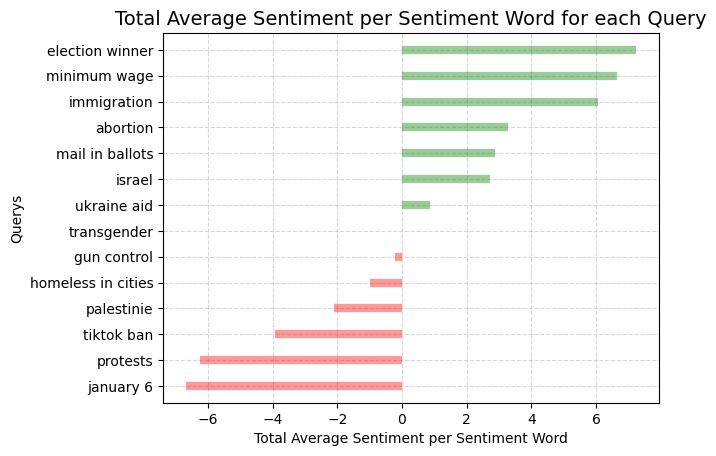

In [35]:
plot_divergent_bars('Average Sentiment per Sentiment Word', topicsDict)

The figure below shows the Total Average Sentiment per Word for each of our topics. Where the name of the topic is on the y-axis and the total average sentiment per word is on the x-axis.

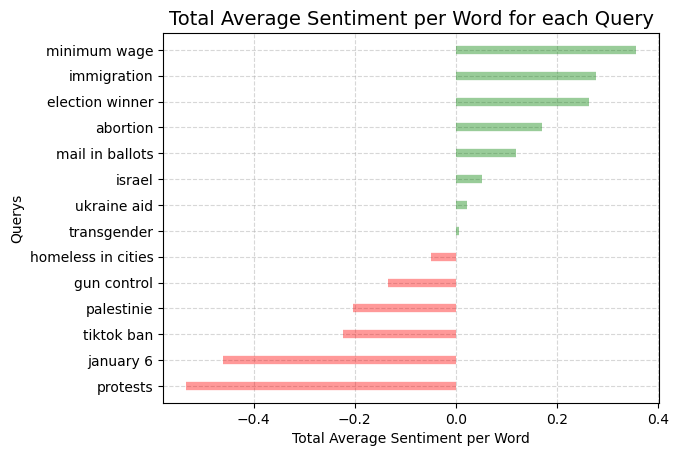

In [36]:
plot_divergent_bars('Average Sentiment per Word', topicsDict)

## Bipolar Topic vs. Article Sentiment

We can further our analysis of each bipolar topic by looking at the distribution of sentiment amongst the articles. The benefit of this analysis is that we can see whether the total sentiment is being influenced by many articles or just a few.

To start, we need a fucntion to iterate through the topic dictionary and insert a column that labels each article as positive or negative.

In [37]:
#Nick Iman's Code

#takes a DataFrame dictionary; categorizes each article and stores it in a new column, `sentiment`; returns a new dictionary with this column added to each topic DataFrame
def categorizeArticles(queryDict):

    newQueryDict = queryDict.copy()

    queryKey = []               #list to keep track of key order
    queryCategorized = []       #list to keep track of DataFrame order

    for key in newQueryDict.keys():      #iterates through the DataFrame dictionary keys

        query = newQueryDict[key]        #pulls DataFrame from dictionary
        articleCategories = []        #list to keep track of the determined article sentiment
        queryKey.append(key)          #adds the key to the key order list

        for articleSentiment in query['Average Sentiment per Word']:     #iterates through the 'Average Sentiment per Word' value for each article
            
            if articleSentiment > 0:                            #checks if the value is positive; adds the sentiment category to the determined sentiment list
                articleCategories.append('Positive')
            elif articleSentiment < 0:                          #checks if the value is negative; adds the sentiment category to the determined sentiment list
                articleCategories.append('Negative')
            else:                                               #checks if there is no sentiment value; adds the sentiment category to the determined sentiment list
                articleCategories.append('No Sentiment')

        query.insert(8, 'Sentiment', articleCategories)        #inserts the new category column into the DataFrame
        queryCategorized.append(query)                      #adds altered DataFrame into the DataFrame list
    
    return {queryKey[x]: queryCategorized[x] for x in range(len(queryKey))}         #returns a new DataFrame dictionary with the altered DataFrames

Pie charts will be a simple and clear way to display the article sentiment distribution.

We need a funciton that can read the sentiment categories of the articles and display a pie chart showing the distribution of the articles' sentiment

In [38]:
import matplotlib.pyplot as plt

#takes a DataFrame and string; counts the sentiment categories in the DataFrame and creates a pie chart titled with the associated key
def articlePieCharts(query, key):

    categoryList = []          #creates a list to store the article categories
    for articleCategory in query['Sentiment']:      #stores the article categories in the list
        categoryList.append(articleCategory)

    labels = 'Positive','Negative', 'No Sentiment'      #creates the labels for the pie chart

    sizes = [categoryList.count('Positive'), categoryList.count('Negative'), categoryList.count('No Sentiment')]    #calculates the size values for the pie chart

    plt.figure(figsize=(5,5))           #sets the size for the pie chart
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=270)    #creates the pie chart

    plt.title("Article Sentiment Distribution for "+key)    #titles the pie chart

    plt.show()      #displays the pie chart

Now we can apply the functions defined above to visualize the distribution of positive, negative, and no sentiment articles for each topics. For a less cluttered notebook, we will select 3 interesting topics to visualize.

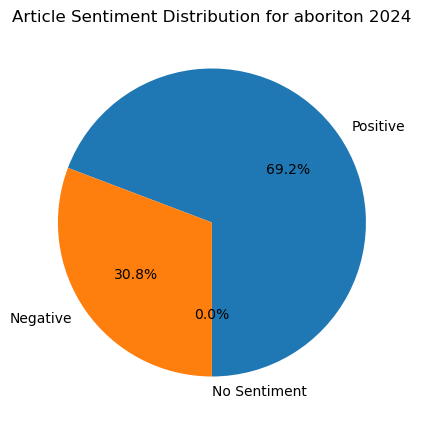

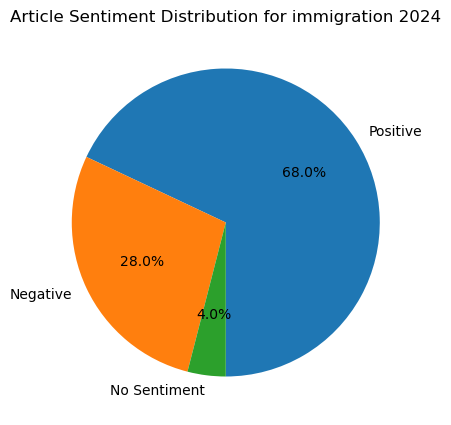

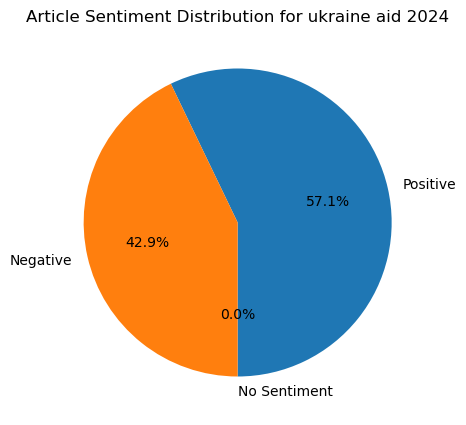

In [39]:
topicsDictCategorized = categorizeArticles(topicsDict)      #creates a new dictionary with the included sentiment category

articlePieCharts(topicsDictCategorized['abortion 2024'], 'aboriton 2024')                         #this cell fails if run twice
articlePieCharts(topicsDictCategorized['immigration 2024'], 'immigration 2024')
articlePieCharts(topicsDictCategorized['ukraine aid 2024'], 'ukraine aid 2024')

## Distribution Analysis of Bipolar Topic Sentiment

To see if there is a relationship between the topic and sentiment, we decided to use a boxplot. Below is a function that creates a pandas data frame with each article from all the topics and calculates the average sentiment per word for each article.

In [40]:
# Code by Justin Dean
import string
import numpy
def create_boxplot():
    tempDF = pandas.DataFrame()
    #Combine the DataFrames from in topicsDict
    for i in topicsDict.keys():
        temp = topicsDict[i].copy()
        temp['Topics'] = str(i)[:-5]
        tempDF = pandas.concat([tempDF, temp])
    #Creates a DataFrame with the data needed to create a boxplot
    docuDF = pandas.DataFrame({'Topics': tempDF.Topics, 'Document': tempDF.Words})
    #Cleans the text data and creates a word bag 
    docuDF['Bag'] = docuDF['Document'].apply(lambda x: x.translate(str.maketrans(string.punctuation + string.digits, 42*' ')).lower().split(' '))
    docuDF['Bag'] = docuDF['Bag'].apply(lambda x: [i for i in x if i != ''])
    # Gets the length of the word bag
    docuDF['Length'] = docuDF['Bag'].apply(lambda x: len(x))
    # Calculate the Sentiment
    docuDF['Sentiment'] = docuDF['Bag'].apply(lambda x: [(sentiment.SentimentValue[sentiment.Word == i]) for i in x if i in sentiment.Word.to_list()])
    docuDF['Sentiment'] = docuDF['Sentiment'].apply(lambda l: [ int(y) for x in l for y in x])
    # Remove missing data
    docuDF['Sentiment'] = docuDF['Sentiment'].apply(lambda x: x if len(x) != 0 else numpy.nan)
    docuDF = docuDF.dropna()
    # Calculate the average sentiment
    docuDF['Average Sentiment'] = docuDF['Sentiment'].apply(lambda x: sum(x)/len(x))

    return docuDF

Below is a function for plotting the box plot of average sentiment, grouped by the topics.This function takes an argument, `include`, that contains topics that will be shown in the boxplot.

In [41]:
def plot_boxplot(include, boxplotDF):
    # Filter DataFrame for topics we don't want to include
    filter = boxplotDF.Topics.apply(lambda x : x in include)
    # Plot the boxplot
    plot = boxplotDF[filter].boxplot(column=['Average Sentiment'], by = 'Topics')
    plot.set_ylabel("Average Sentiment")

The figure below shows a boxplot of the average sentiment grouped by the topic. The x-axis has the names of topics and the y-axis has the average sentiment. Each box represents the distribution of average sentiment for the corresponding topic. Furthermore the green lines represent the median and the black circles represent outliers.

In [42]:
# This may take a some time to finish
boxDF = create_boxplot()

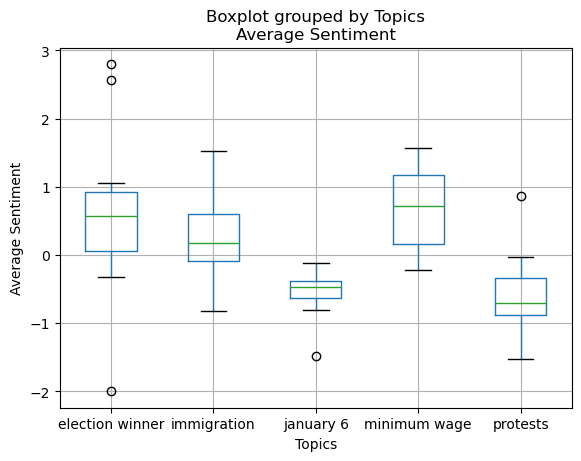

In [43]:
included_topics = ['january 6','election winner','immigration', 'protests','minimum wage']
plot_boxplot(included_topics, boxDF)

## Bipolar Topic vs. Persuasive Intensity

Another angle we can use to analyze each topic is to determine the intensity of sentiment for each topic. The metric 'intesity of sentiment' indicates the level of persuasiveness being put towards each topic, an it can give us an idea of where Google is trying to be persuasive.

A bar chart will serve as a good tool of comparison between the topics. These functions calculate the intensity and create the bar chart:

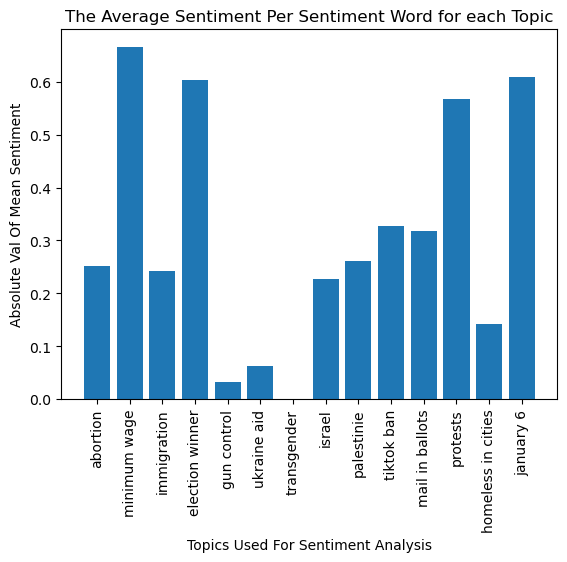

<Figure size 1000x1500 with 0 Axes>

In [44]:
#Aiden Shea's Code

import matplotlib.pyplot as plt

def create_bar(word_type):
    topic = []
    avg_per_sentword = []
    
    # Checks for correct input data
    if word_type == 'Average Sentiment per Sentiment Word':
        for i in topicsDict.keys():
            topic.append(str(i)[:-5])
            avg_per_sentword.append(abs(topicsDict[i]['Average Sentiment per Sentiment Word'].mean()))
        totalTopicSentiment = pandas.DataFrame({'Topic':topic, 'Average Sentiment per Sentiment Word':avg_per_sentword})

        return totalTopicSentiment
def plot_graph(word_type):
        
    totalTopicSentiment = create_bar(word_type)
        
    # Plots results
    x = totalTopicSentiment['Topic']
    y = totalTopicSentiment['Average Sentiment per Sentiment Word']
    labels = [i for i in totalTopicSentiment['Topic']]

    # Create bar plot
    plt.bar(x, y)
    plt.xticks(x, labels, rotation ='vertical')


    # Add labels and title
    plt.xlabel('Topics Used For Sentiment Analysis')
    plt.ylabel('Absolute Val Of Mean Sentiment')
    plt.title('The Average Sentiment Per Sentiment Word for each Topic')
    plt.figure(figsize=(10, 15))
    
plot_graph('Average Sentiment per Sentiment Word')

## Bipolar Topics vs. Article Charactersitics (MDS)

In this analysis, we wanted to visualize the relationship between bipolar topics based on their article characteristics using MDS. The MDS plot revealed that topics closer together tend to be similar more by characteristics, and those far apart are not so similar. Also, the color gives a representation of the Average sentiment per word giving more incite in relationships. From the plot, we see clusters being formed and how which topics/queries relate

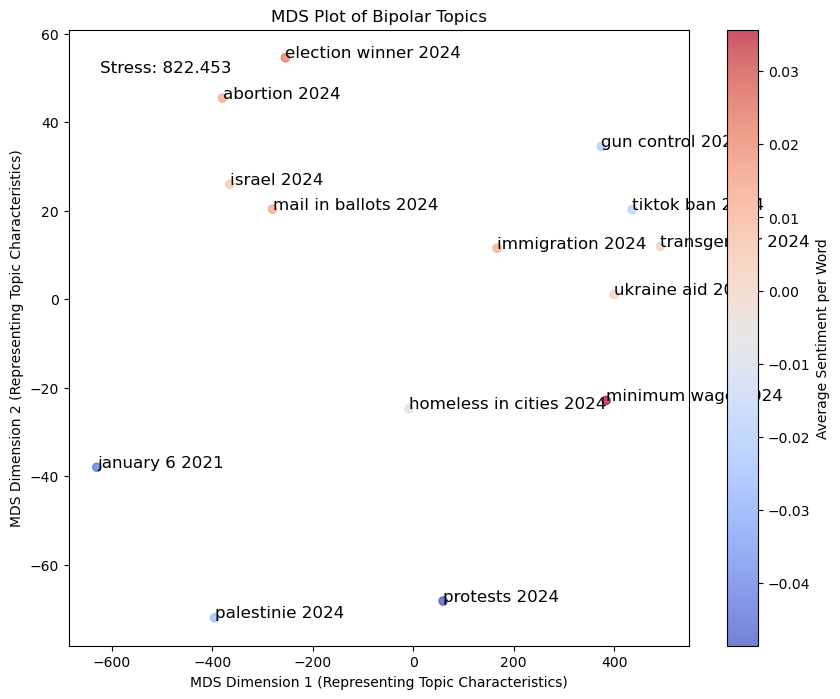

In [45]:
# Anthony's Part
# Visualizes the relationship between topics based on their article characteristics, and
# we can see the topics that are closer happen to be considered more similar, and topics that
# are apart are less similar.

# imports necessary libraries
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import pandas as pd


# Select the relevant columns from the DataFrame reducedTable
mds_data = reducedTable[['Query', 'Average Word Count', 'Average Sentiment Word Count', 'Average Total Sentiment', 'Average Sentiment per Word']]

# Compute the distance matrix between all pairs of samples in the selected data
distance_matrix = euclidean_distances(mds_data.iloc[:, 1:])

# Perform MDS and reduce dim to 2 dim 
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
#contains the coordinates of the data points in the reduced space
mds_coords = mds.fit_transform(distance_matrix)

# Compute stress value
stress = mds.stress_

# Create a DataFrame with coordinates from the MDS analysis along with the query names and the average sentiment per word
mds_df = pd.DataFrame(mds_coords, columns=['MDS Dimension 1', 'MDS Dimension 2'])
mds_df['Query'] = mds_data.Query.values
mds_df['Average Sentiment per Word'] = mds_data['Average Sentiment per Word']

# Visualize the MDS plot
plt.figure(figsize=(10, 8))

# Plot the scatter points with color representing 'Average Sentiment per Word'
scatter = plt.scatter(mds_df['MDS Dimension 1'], mds_df['MDS Dimension 2'], c=mds_df['Average Sentiment per Word'], cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Average Sentiment per Word')

#this loop adds annotations for each topic at its coreesponding postion in the MDS plot
for i, topic in enumerate(mds_df.Query):
    plt.annotate(topic, (mds_df.iloc[i, 0], mds_df.iloc[i, 1]), fontsize=12)
#Labeeling the axees and Titling
plt.xlabel('MDS Dimension 1 (Representing Topic Characteristics)')
plt.ylabel('MDS Dimension 2 (Representing Topic Characteristics)')
plt.title('MDS Plot of Bipolar Topics')
#adds stress 
plt.text(0.05, 0.95, f'Stress: {stress:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

## Bipolar Questions and Google's Overall Political Sentiment Pie Charts

To get a better understanding of the summation of the political sentiment of all the questions, pie charts were created to compare the number of question sentiment results that were more leanient towards a specific side of that poltical axis.

The function below creates and displays a pie chart for the specified poltical axis.

In [46]:
#Code by Liam May

def politicalPieCharts(politicalSentiment, axes_type):
    labels = []
    sizes = []
    colors = ['red','blue']
    normSentiment = politicalSentiment[axes_type].tolist()
    positiveSentiment = [sent for sent in normSentiment if sent > 0]
    sizes = [len(positiveSentiment), (len(normSentiment)-len(positiveSentiment))]
    if (axes_type == 'Totalitarian-Libertarian AvSentPerWord'):
        labels=['Totalitarian', 'Libertarian']
        colors = ['darkred', 'yellowgreen']
    elif (axes_type == 'Collectivist-Individualist AvSentPerWord'):
        labels = ['Collectivist', 'Individualist']
        colors = ['purple', 'orange']
    elif (axes_type == 'Progressive-Conservative AvSentPerWord'):
        labels = ['Progressive', 'Conservative']
        colors =['darkblue', 'red']

    plt.figure(figsize=(8, 8))  # Specify the size of the plot
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=270, colors=colors)

    # Add a title
    plt.title('Sentiment of Query Results')

    # Display the plot
    plt.show()

These lines run this function for multiple axes:

The pie chart below shows that on the Totalitarian-Libertarian axis, Google's general political sentiment was roughly even.

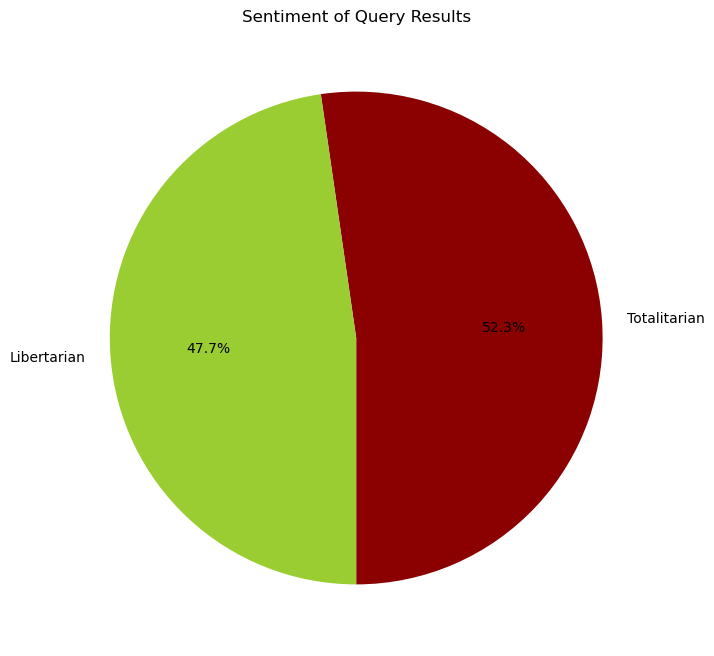

In [47]:
politicalPieCharts(politicalSentiment, 'Totalitarian-Libertarian AvSentPerWord')

The pie chart below shows that on the Collectivist-Individualist axis, Google's general political sentiment leaned somewhat towards collectivist.

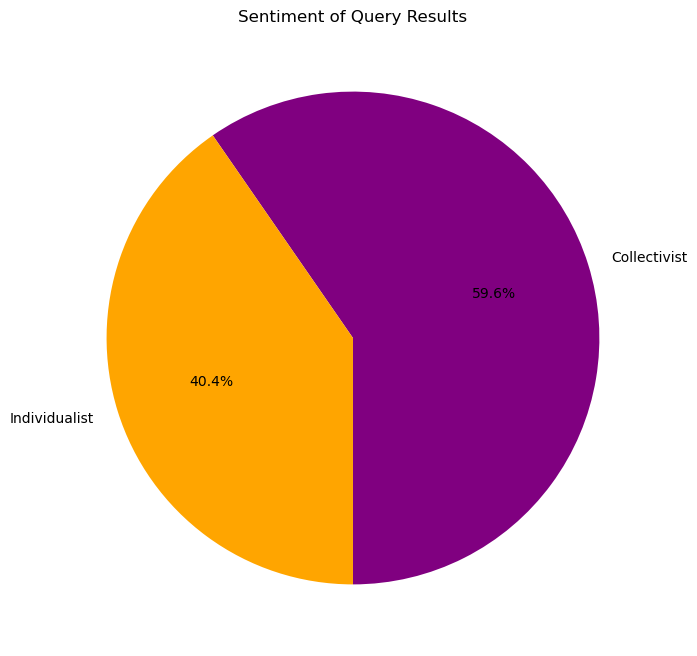

In [48]:
politicalPieCharts(politicalSentiment, 'Collectivist-Individualist AvSentPerWord')

The pie chart below shows that on the Progressive-Conservative axis, Google's general political sentiment leaned somewhat towards progressive.

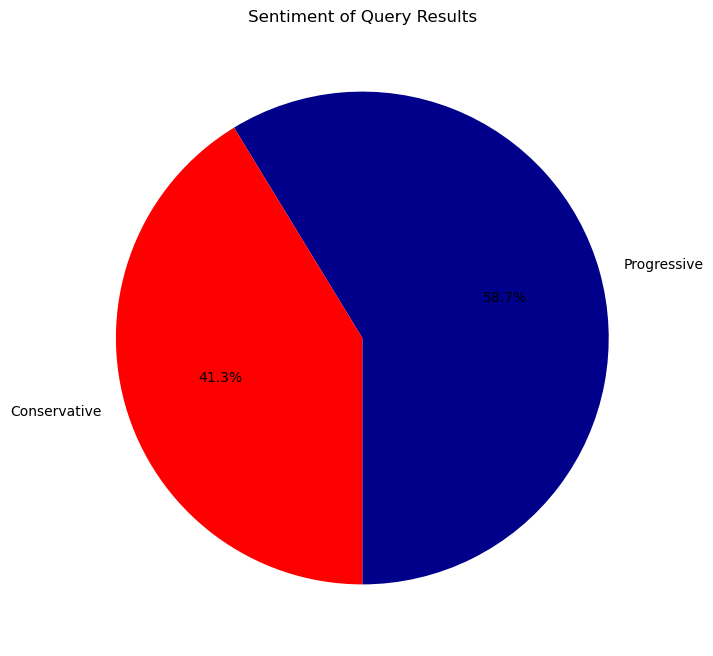

In [49]:
politicalPieCharts(politicalSentiment, 'Progressive-Conservative AvSentPerWord')

## Bipolar Questions vs. Topic Ideology and Text Clustering (Political Compass)

Now that we have a better undserstanding of the general poltical sentiment of Google search results, we need to break down the specific questions that Google was biased on, and if there are any larger groups of question topics that Google has a general political bias towards. The following visualization displays a 3D political sentiment compas of each question and also colors clusters of questions differently to give insight into whether certain groups of questions have a different poltical sentiment bias than others.

This function creates a 3D scatter plot for the poltical scoring of each question's average sentiment per word. It also colors and groups points based on their clustering as previously determined:

In [50]:
#Code by Liam May

import plotly.graph_objs as go

def create3DPoliticalScatter(politicalSentiment):
    # Sample data
    x = politicalSentiment['Totalitarian-Libertarian AvSentPerWord'].tolist()
    y = politicalSentiment['Collectivist-Individualist AvSentPerWord'].tolist()
    z = politicalSentiment['Progressive-Conservative AvSentPerWord'].tolist()
    labels = politicalSentiment['Query']

    data = []
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'brown', 'black', 'cyan', 'magenta', 'crimson',
            'darkred', 'firebrick', 'darkorange', 'coral', 'tomato', 'gold', 'limegreen', 'forestgreen', 'seagreen',
            'dodgerblue', 'royalblue', 'indigo', 'darkviolet', 'mediumpurple', 'darkgray', 'lightgray', 'brown', 'saddlebrown',
            'sienna', 'peru','red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'brown', 'black', 'cyan', 'magenta', 
            'crimson', 'darkred', 'firebrick', 'darkorange', 'coral', 'tomato', 'gold', 'limegreen', 'forestgreen', 'seagreen',
            'dodgerblue', 'royalblue', 'indigo', 'darkviolet', 'mediumpurple', 'darkgray', 'lightgray', 'brown', 'saddlebrown',
            'sienna', 'peru', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'brown', 'black', 'cyan', 'magenta', 
            'crimson','darkred', 'firebrick', 'darkorange', 'coral', 'tomato', 'gold', 'limegreen', 'forestgreen', 'seagreen',
            'dodgerblue', 'royalblue', 'indigo', 'darkviolet', 'mediumpurple', 'darkgray', 'lightgray', 'brown', 'saddlebrown',
            'sienna', 'peru','red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'brown', 'black', 'cyan', 'magenta', 
            'crimson','darkred']
    color_index=0

    for i in range(0,num_clusters):
        group_x = [e for index, e in enumerate(x) if i==cluster_labels[index]]
        group_y = [e for index, e in enumerate(y) if i==cluster_labels[index]]
        group_z = [e for index, e in enumerate(z) if i==cluster_labels[index]]
        group_labels = [e for index, e in enumerate(labels) if i==cluster_labels[index]]
        # Create trace for scatter plot
        # Create trace for scatter plot with labels
        if(len(group_x)>0):
            scatter_trace = go.Scatter3d(
                x=group_x,
                y=group_y,
                z=group_z,
                mode='markers',
                marker=dict(
                    size=3,  # Change the size of markers here
                    color=colors[color_index],
                    opacity=0.7
                ),
                text=group_labels,  # Set labels for each point
                hoverinfo='text',  # Show text only on hover
                name = ('Cluster '+str(i))
            )
            color_index = color_index + 1
            data.append(scatter_trace)

    # Create trace for center of mass point
    center_point = go.Scatter3d(
        x=[sum(x)/len(x)],
        y=[sum(y)/len(y)],
        z=[sum(z)/len(z)],
        mode='markers',
        marker=dict(
            size=6,
            color='red',  # Change color if desired
            opacity=0.5
        ),
        text=['Google'],
        textposition='bottom center',  # Adjust label position
        name='Google'
    )
    data.append(center_point)
    

    # Create trace for x-axis
    x_axis_trace = go.Scatter3d(
        x=[-0.25, 0.25],  # X coordinates of line
        y=[0, 0],            # Y coordinates of line
        z=[0, 0],            # Z coordinates of line
        mode='lines',        # Set mode to 'lines'
        line=dict(color='black', width=1),  # Set line color and width
        name='Totalitarian Sentiment'
    )
    data.append(x_axis_trace)

    # Create trace for y-axis
    y_axis_trace = go.Scatter3d(
        x=[0, 0],            # X coordinates of line
        y=[-0.25, 0.25],  # Y coordinates of line
        z=[0, 0],            # Z coordinates of line
        mode='lines',        # Set mode to 'lines'
        line=dict(color='black', width=1),  # Set line color and width
        name='Collectivist Sentiment'
    )
    data.append(y_axis_trace)

    # Create trace for z-axis
    z_axis_trace = go.Scatter3d(
        x=[0, 0],            # X coordinates of line
        y=[0, 0],            # Y coordinates of line
        z=[-0.25, 0.25],  # Z coordinates of line
        mode='lines',        # Set mode to 'lines'
        line=dict(color='black', width=1),  # Set line color and width
        name='Progressive Sentiment'
    )
    data.append(z_axis_trace)

    # Create layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='Totalitarian'),
            yaxis=dict(title='Collectivist'),
            zaxis=dict(title='Progressive')
        )
    )

    # Create figure
    fig = go.Figure(data=data, layout=layout)

    # Display the plot
    fig.show()

This code runs the function:

In [51]:
create3DPoliticalScatter(politicalSentiment)

As we can see from this 3D graph, there seems to be a correlation between totalitarian, collectivist, and progressive sentiments and a correlation between libertarian, individualist, and conservative sentiments, showing that Google generally reflects mainstream political groups, as these correlations are also very common in U.S. politics. 

This graph also shows us that Google is biased differently for different question groups. For instance, enviromental question sentiment were very progressively skewed.

# **Conclusions**

Based on our analysis, we determined that, on average, Google returns relatively biased search results in response to bipolar search queries.

* The analysis of Bipolar Topics vs. Sentiment section clearly shows an average sentiment that significantly deviates from zero, indicating bias in the search results for almost all the queries.

We know that this conclusion is accurate due to multiple reasons:

* The analysis of the distribution of articles supports this claim even further. The Bipolar Topic vs. Article Sentiment pie charts indicate that sentiment bias exists outside of the influence of outliers/extreme articles, since there is almost no neutral article percentage. 
* The Bipolar Topic Distribution analysis boxplots show that a majority of topic queries do not have an average sentiment of zero inside of its interquartile range meaning that over half of the search results have either a positive or negative average sentiment.
* The Analysis of Article Characteristics section's multidimensional scaling rules out any relationship between a bias and text characteristics (i.e. length, number of sentiment words, etc.) because there is no observable pattern between text similarities and sentiment. This reinforces the integrity of our conclusion.

With the establishment that Google is biased, we determined **how** google was biased. Using the political ideology dataset we constructed as well as the bipolar question data set, we were able to come to the following conclusions:

* The distribution on the Bipolar Questions vs. Google pie charts describes Google's bias as Collectivist, Progressive, and slightly Totalitarian.
* However, the centroid representing Google's position on the political compass only places them slightly in those directions, by approximately 0.01 sentiment per word in each direction.
* Combined, these show that Google is only slightly biased overall in these ways.

However, when political sentiment is broken down into clusters, it shows that Google is more biased towards certain topics:
* Google was much more significantly skewed towards a Collectivist, Progressive, and Totalitarian sentiment for enviromental questions, healthcare questions, education questions, and racial inequality questions.
* Google was much more significantly skewed towards a Libertarian, Individualist, and Conservative sentiment for gun questions and court system questions.
* Google was a little more case by case and generally less biased on policing questions, voting questions, employement questions, immigration questions, tax questions, abortion questions, and immigation questions.

While many individuals would see these results and think "yes, it is obviously biased", it is likely that they are not thinking about this bias when utilizing Google's search engine. Moreover, although our analysis only places Google at a slight bias, it begs the question: why is there any bias at all? Should I be exposed to different articles to understand the other side? We believe so.

It's important to understand that this bias exists, and the power that sentiment can have over many search queries and articles. We hope that by presenting our findings to you, you can be more concious about bias in your search results, whether its on the browser, youtube, tiktok, facebook, or any other information platform.

**Future Work**

Reflecting on the analyses we performed, there are a questions whose answers could improve our code and lead to better results:

* Does our ideological dataset correctly represent the ideologies? It may introduce minimal personal bias, so how can we eliminate this?
* How does Google's sentiment differ from average human sentiment? How different do these two have to be for Google to be considered baised against public opinion?
* Further testing: What is the sentiment of the first 5 search results? (likely to be the first articles people click on)
* How does Google's bias score compare to other search engines like Microsoft Bing or Firefox?
* How can we incorporate cookies with Google's algorithms to find out how its bias might change with time or for different users?

## **References**

[1]  Nielsen, F. Å. (2011). A new ANEW: Evaluation of a word list for sentiment analysis in microblogs. arXiv preprint arXiv:1103.2903, 718, 93-98. 